In [14]:
import concurrent.futures
import os
from tqdm.auto import tqdm
import io
import numpy as np
import torchvision
import pandas as pd

from torch import nn, optim
import psycopg2
from IPython.display import clear_output
from pandas import DataFrame
from sqlalchemy import create_engine
import requests
from PIL import Image
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from torchvision import transforms

In [15]:
torch.cuda.empty_cache()

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [16]:
# image = Image.open(io.BytesIO(data_postgres[0][9]))
# 
# # Display the image using Matplotlib
# plt.imshow(image)
# plt.axis('off')  # Optional: Turn off axis
# plt.show()

In [17]:
transformation = transforms.Compose(
    [    
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

In [18]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        
        
        

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = self.data[index]
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.data)

In [20]:

def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
                train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                    val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                    train_epoch_true_hits.sum()
                    / train_epoch_true_hits.size(0)
                    / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                    val_epoch_true_hits.sum()
                    / val_epoch_true_hits.size(0)
                    / val_dataloader.batch_size
            ).item(),
        )

In [21]:

conn_select = psycopg2.connect(
    database="hse_medical",
    user='hse_medical',
    password='123456',
    host='127.0.0.1',
    port='5450',
    options="-c search_path=analyze_medical"
)

conn_select.autocommit = True

transform = transforms.ToTensor()

def get_connection():
    return conn_select

In [22]:

cursor = conn_select.cursor()

sql1 = f'''select 
    target,
    image from medical_pictures_train;'''
cursor.execute(sql1)
data_postgres = cursor.fetchall()
print(f"datatrain_size : {len(data_postgres)}")
cursor.close()
targets = []
images = []
for data in data_postgres:
    targets.append(data[0])
    image = Image.open(io.BytesIO(data[1]))
    images.append(image)
    

data_train = CustomDataset(images, targets,transform=transformation)




datatrain_size : 15588


In [23]:
cursor_test= conn_select.cursor()

sql2 = f'''select 
    target,
    image from medical_pictures_test;'''
cursor_test.execute(sql2)
data_postgres_test = cursor_test.fetchall()
cursor_test.close()
targets_test = []
images_test = []


for data in data_postgres_test:
    targets_test.append(data[0])
    bytes_io = io.BytesIO(data[1])
    image_open = Image.open(bytes_io)
    images_test.append(image_open)
    
    

data_test = CustomDataset(images_test, targets_test,transform=base_transform)

In [24]:
train_dataloader = torch.utils.data.DataLoader(
    data_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    data_test, batch_size=32, shuffle=False, num_workers=4
)



In [25]:

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 37 * 37, 512)
        self.fc2 = nn.Linear(512, 23)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 37 * 37)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN()

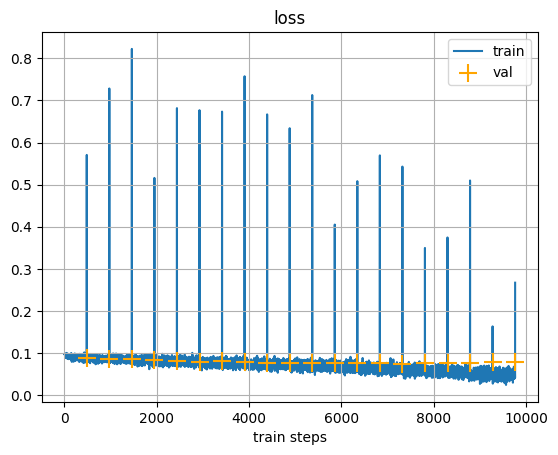

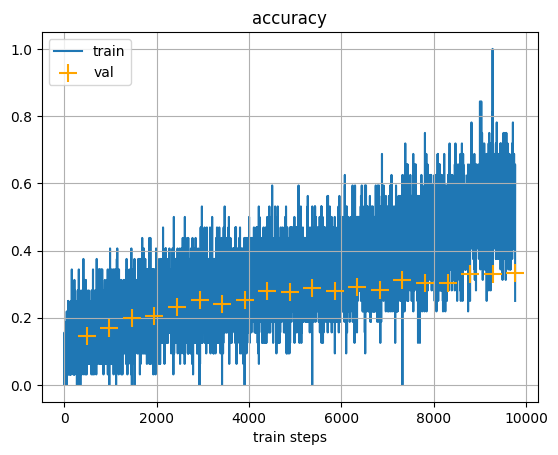

Train loss: 0.04705530032515526
Train acc: 0.5388063788414001
Val loss: 0.0797385424375534
Val acc: 0.3320932686328888


In [26]:

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model=model,
      criterion= criterion,
      optimizer= optimizer,
      train_dataloader= train_dataloader,val_dataloader= val_dataloader,n_epochs=20)